In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import xgboost as xgb
import os

from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

target = 'fraud'
# Any results you write to the current directory are saved as output.

C:\Users\erica\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\erica\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df= pd.read_csv('C:\\Users\\erica\\OneDrive\\Documents\\all\\uconn_comp_2018_train.csv',na_values=['NaN',''])

In [3]:
test = pd.read_csv('C:\\Users\\erica\\OneDrive\\Documents\\all\\uconn_comp_2018_test.csv',na_values=['NaN',''])

In [4]:
df.isnull().sum()

claim_number                 0
age_of_driver                0
gender                       0
marital_status               5
safty_rating                 0
annual_income                0
high_education_ind           0
address_change_ind           0
living_status                0
zip_code                     0
claim_date                   0
claim_day_of_week            0
accident_site                0
past_num_of_claims           0
witness_present_ind        132
liab_prct                    0
channel                      0
policy_report_filed_ind      0
claim_est_payout            17
age_of_vehicle               8
vehicle_category             0
vehicle_price                0
vehicle_color                0
vehicle_weight               0
fraud                        0
dtype: int64

In [5]:
df = df.fillna({"marital_status": 1})

In [6]:
df = df.fillna({"witness_present_ind": 0})

In [7]:
test = test.fillna({"marital_status": 1})

In [8]:
test = test.fillna({"witness_present_ind": 0})

In [9]:
test_claim_number=test.claim_number

df[df['fraud']==-1]

,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,...,liab_prct,channel,policy_report_filed_ind,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud
82,132,32,F,1.0,66,34676,1,0,Own,85060,...,8,Broker,0,7142.277506,9.0,Compact,18070.366510,black,7337.606862,-1
12825,21336,47,F,1.0,90,38505,0,1,Own,80034,...,23,Broker,0,5952.444157,4.0,Large,8679.988214,silver,30798.717700,-1
15515,25842,39,F,1.0,66,36632,0,1,Own,80044,...,9,Online,0,4554.701439,5.0,Large,16682.989780,silver,26112.502690,-1


In [10]:
df.drop([82,12825,15515],inplace= True)

In [11]:
df.shape

(17995, 25)

In [12]:
#change gender (M/F) to 0/1
def decode(value):
    if value=='M':
        return 0
    else:
        return 1
df['gender']=df['gender'].apply(decode)

In [13]:
test['gender']=test['gender'].apply(decode)

In [14]:
def decode(value):
    if value==1.0:
        return 1
    else:
        return 0
df['marital_status']=df['marital_status'].apply(decode)

In [15]:
test['marital_status']=test['marital_status'].apply(decode)

In [16]:
def decode(value):
    if value=='Own':
        return 1
    else:
        return 0
df['living_status']=df['living_status'].apply(decode)

In [17]:
test['living_status']=test['living_status'].apply(decode)

In [18]:
ZipData = pd.read_csv('C:\\Users\\erica\\OneDrive\\Documents\\all\\free-zipcode-database.csv') #Download this file, and put into data folder.
ZipData = ZipData[ZipData['Country'] == "US" ] #Select Zipcode belong to US.
ZipData = ZipData[['Zipcode', 'ZipCodeType', 'City', 'State', 'Lat', 'Long']] # Select columns that are important.
ZipData.head(20)

,Zipcode,ZipCodeType,City,State,Lat,Long
0,704,STANDARD,PARC PARQUE,PR,17.96,-66.22
1,704,STANDARD,PASEO COSTA DEL SUR,PR,17.96,-66.22
2,704,STANDARD,SECT LANAUSSE,PR,17.96,-66.22
3,704,STANDARD,URB EUGENE RICE,PR,17.96,-66.22
4,704,STANDARD,URB GONZALEZ,PR,17.96,-66.22
5,704,STANDARD,URB LA FABRICA,PR,17.96,-66.22
6,704,STANDARD,URB MONTE SORIA 2,PR,17.96,-66.22
7,704,STANDARD,VILLAS DEL COQUI,PR,17.96,-66.22
8,705,STANDARD,AIBONITO,PR,18.14,-66.26
9,705,STANDARD,BDA SAN LUIS,PR,18.14,-66.26


In [19]:
ZipData = ZipData.drop_duplicates('Zipcode') #Drop dup zipcode and keep the first one for each zip.
ZipData.reset_index(inplace = True) #Reset index
ZipData.drop(columns= ['index'], inplace= True) #drop extra column
ZipData.head(3)

,Zipcode,ZipCodeType,City,State,Lat,Long
0,704,STANDARD,PARC PARQUE,PR,17.96,-66.22
1,705,STANDARD,AIBONITO,PR,18.14,-66.26
2,610,STANDARD,ANASCO,PR,18.28,-67.14


In [20]:
# Merge train data set with the ZipData set.
MergeOnZip = pd.merge(df, ZipData, how = 'left', left_on = df['zip_code'], right_on= ZipData['Zipcode'])
MergeOnZip.head(3)

,key_0,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,...,vehicle_price,vehicle_color,vehicle_weight,fraud,Zipcode,ZipCodeType,City,State,Lat,Long
0,80006,1,46,0,1,85,38301,1,1,0,...,12885.45235,white,16161.33381,0,80006.0,PO BOX,ARVADA,CO,39.82,-105.10
1,15021,3,21,1,0,75,30445,0,1,0,...,29429.45218,white,28691.96422,0,15021.0,STANDARD,BURGETTSTOWN,PA,40.38,-80.39
2,20158,4,49,1,0,87,38923,0,1,1,...,21701.18195,white,22090.94758,1,20158.0,STANDARD,HAMILTON,VA,39.13,-77.66


In [21]:
df = MergeOnZip.drop(columns= ['key_0','Zipcode','zip_code','ZipCodeType'])
df.head(3)

,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,claim_date,...,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud,City,State,Lat,Long
0,1,46,0,1,85,38301,1,1,0,12/16/2016,...,9.0,Compact,12885.45235,white,16161.33381,0,ARVADA,CO,39.82,-105.10
1,3,21,1,0,75,30445,0,1,0,2/12/2015,...,4.0,Large,29429.45218,white,28691.96422,0,BURGETTSTOWN,PA,40.38,-80.39
2,4,49,1,0,87,38923,0,1,1,12/6/2016,...,3.0,Compact,21701.18195,white,22090.94758,1,HAMILTON,VA,39.13,-77.66


In [22]:
zipData = pd.read_csv('C:\\Users\\erica\\OneDrive\\Documents\\all\\free-zipcode-database.csv') #Download this file, and put into data folder.
zipData = zipData[zipData['Country'] == "US" ] #Select Zipcode belong to US.
zipData = zipData[['Zipcode', 'ZipCodeType', 'City', 'State', 'Lat', 'Long']] # Select columns that are important.
zipData.head(20)

,Zipcode,ZipCodeType,City,State,Lat,Long
0,704,STANDARD,PARC PARQUE,PR,17.96,-66.22
1,704,STANDARD,PASEO COSTA DEL SUR,PR,17.96,-66.22
2,704,STANDARD,SECT LANAUSSE,PR,17.96,-66.22
3,704,STANDARD,URB EUGENE RICE,PR,17.96,-66.22
4,704,STANDARD,URB GONZALEZ,PR,17.96,-66.22
5,704,STANDARD,URB LA FABRICA,PR,17.96,-66.22
6,704,STANDARD,URB MONTE SORIA 2,PR,17.96,-66.22
7,704,STANDARD,VILLAS DEL COQUI,PR,17.96,-66.22
8,705,STANDARD,AIBONITO,PR,18.14,-66.26
9,705,STANDARD,BDA SAN LUIS,PR,18.14,-66.26


In [23]:
zipData = zipData.drop_duplicates('Zipcode') #Drop dup zipcode and keep the first one for each zip.
zipData.reset_index(inplace = True) #Reset index
zipData.drop(columns= ['index'], inplace= True) #drop extra column
zipData.head(3)

,Zipcode,ZipCodeType,City,State,Lat,Long
0,704,STANDARD,PARC PARQUE,PR,17.96,-66.22
1,705,STANDARD,AIBONITO,PR,18.14,-66.26
2,610,STANDARD,ANASCO,PR,18.28,-67.14


In [24]:
mergeOnZip = pd.merge(test, zipData, how = 'left', left_on = test['zip_code'], right_on= zipData['Zipcode'])
mergeOnZip.head(3)

,key_0,claim_number,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,...,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,Zipcode,ZipCodeType,City,State,Lat,Long
0,50048,2,39,0,1,73,36633,1,0,1,...,Large,24360.59273,silver,26633.27819,50048.0,STANDARD,CASEY,IA,41.50,-94.52
1,85068,9,56,0,1,63,40252,1,1,1,...,Large,39710.42665,other,15875.34874,85068.0,PO BOX,PHOENIX,AZ,33.67,-112.06
2,20115,11,39,1,0,75,36634,1,1,1,...,Medium,50327.56618,silver,21365.05932,20115.0,STANDARD,MARSHALL,VA,38.87,-77.85


In [25]:
test = mergeOnZip.drop(columns= ['key_0','Zipcode','zip_code','ZipCodeType'])

In [26]:
def decode(value):
    if value==0.0:
        return 0
    else:
        return 1
df['witness_present_ind']=df['witness_present_ind'].apply(decode)

In [27]:
test['witness_present_ind']=test['witness_present_ind'].apply(decode)

In [28]:
df.drop('claim_number',axis=1,inplace=True)
test.drop('claim_number',axis=1,inplace=True)
df.drop('age_of_driver',axis=1,inplace=True)
test.drop('age_of_driver',axis=1,inplace=True)

In [29]:
df['claim_year']=pd.to_datetime(df.claim_date).dt.year.astype(int)
df['claim_month']=pd.to_datetime(df.claim_date).dt.month.astype(int)
df['claim_day']=pd.to_datetime(df.claim_date).dt.day.astype(int)
df.drop('claim_date',axis=1,inplace=True)
test['claim_year']=pd.to_datetime(test.claim_date).dt.year.astype(int)
test['claim_month']=pd.to_datetime(test.claim_date).dt.month.astype(int)
test['claim_day']=pd.to_datetime(test.claim_date).dt.day.astype(int)
test.drop('claim_date',axis=1,inplace=True)

In [30]:
df=pd.get_dummies(df)
test=pd.get_dummies(test)
predictors = [x for x in df.columns if x not in [target]]
dtrain, dvalid = train_test_split(df, test_size=0.2, random_state=42)

In [31]:
def modelfit(alg, X_train, predictors,useTrainCV=True, cv_folds=10, early_stopping_rounds=80):
    if useTrainCV:    
        xgb_param = alg.get_xgb_params()    
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)    
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,metrics='auc'
                          , early_stopping_rounds=early_stopping_rounds)    
        alg.set_params(n_estimators=cvresult.shape[0])
        #Fit the algorithm on the data
        alg.fit(dtrain[predictors], dtrain['fraud'],eval_metric='auc')
        #Predict training set:
        dtrain_predictions = alg.predict(dtrain[predictors])
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
           #Print model report:
        print ("\nModel Report")
        print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['fraud'].values, dtrain_predictions))
        print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['fraud'], dtrain_predprob))
        
        dvalid_predictions = alg.predict(dvalid[predictors])
        dvalid_predprob = alg.predict_proba(dvalid[predictors])[:,1]
        print ("Accuracy : %.4g" % metrics.accuracy_score(dvalid['fraud'].values, dvalid_predictions))
        print ("AUC Score (Valid): %f" % metrics.roc_auc_score(dvalid['fraud'], dvalid_predprob))
        
        test_predprob = alg.predict_proba(test[predictors])[:,1]
        
        feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        return metrics.roc_auc_score(dvalid['fraud'], dvalid_predprob), test_predprob

C:\Users\erica\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.8433
AUC Score (Train): 0.738803


C:\Users\erica\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy : 0.8508
AUC Score (Valid): 0.741008


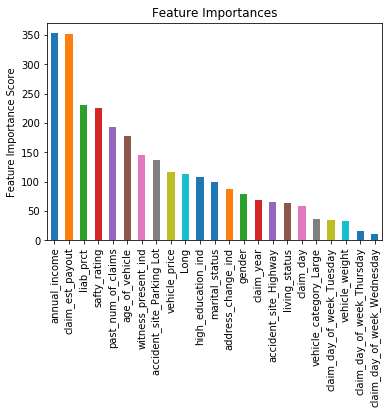

In [46]:
xgb1 = XGBClassifier(
 learning_rate =0.05,
 gamma=0,
 n_estimators=5000,
 max_depth=1,
 min_child_weight=8,
 subsample=1,
 colsample_bytree=1,
 colsample_bylevel=0.49,
 reg_alpha=8,
 sketch_eps=0.3,
 reg_lambda=500,
 objective= 'binary:logistic',
 nthread=9,
 scale_pos_weight=1,
 seed=27)
res,train_res=modelfit(xgb1, dtrain, predictors)


In [42]:
res

0.7410796500920811

In [43]:
submission=pd.DataFrame({'claim_number':test_claim_number,'fraud':train_res})

In [44]:
submission.to_csv("C:\\Users\\erica\\OneDrive\\Documents\\all\\xgboost baseline2.csv", index = False)
#print (submission.shape)